In [ ]:
#US Consumer Finance Complaints Data Prediction using Logistic Regression
#Dataset: https://www.kaggle.com/datasets/kaggle/us-consumer-finance-complaints

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/consumer_complaints.csv")
df["date_received"] = pd.to_datetime(df["date_received"], utc=True)
df.head(5) 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,2013-08-30 00:00:00+00:00,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,2013-08-30 00:00:00+00:00,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,2013-08-30 00:00:00+00:00,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,2013-08-30 00:00:00+00:00,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,2013-08-30 00:00:00+00:00,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


Data Exploration - 507,128 unique values, 18 columns

In [ ]:
df.shape

(555957, 18)

In [ ]:
#check columns
df.dtypes

date_received                   datetime64[ns, UTC]
product                                      object
sub_product                                  object
issue                                        object
sub_issue                                    object
consumer_complaint_narrative                 object
company_public_response                      object
company                                      object
state                                        object
zipcode                                      object
tags                                         object
consumer_consent_provided                    object
submitted_via                                object
date_sent_to_company                         object
company_response_to_consumer                 object
timely_response                              object
consumer_disputed?                           object
complaint_id                                  int64
dtype: object

In [ ]:
#check missing values
df.isnull().values.any()

True

In [ ]:
df.isnull().sum()

date_received                        0
product                              0
sub_product                     158322
issue                                0
sub_issue                       343335
consumer_complaint_narrative    489151
company_public_response         470833
company                              0
state                             4887
zipcode                           4505
tags                            477998
consumer_consent_provided       432499
submitted_via                        0
date_sent_to_company                 0
company_response_to_consumer         0
timely_response                      0
consumer_disputed?                   0
complaint_id                         0
dtype: int64

In [ ]:
df = df[['product', 'consumer_complaint_narrative']]

In [ ]:
#drop NA values
df = df[pd.notnull(df['consumer_complaint_narrative'])]

In [ ]:
df.shape

(66806, 2)

In [ ]:
df.head(10)

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...
190237,Mortgage,Experian is reporting my OPEN and CURRENT Mort...
190238,Mortgage,This complaint is against Wells Fargo Bank for...
190251,Mortgage,I spoke to XXXX of green tree representatives ...
190263,Credit card,i opened XXXX Bank of America credit cards 15-...
190264,Consumer Loan,I applied for a loan with XXXX XXXX and had pu...


In [ ]:
#add a column representing categorical value (product) in numerical value
df['category'] = pd.factorize(df['product'])[0] + 1

In [ ]:
df.head(10)

,product,consumer_complaint_narrative,category
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,1
190135,Consumer Loan,Due to inconsistencies in the amount owed that...,2
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,3
190207,Mortgage,I have an open and current mortgage with Chase...,3
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,3
190237,Mortgage,Experian is reporting my OPEN and CURRENT Mort...,3
190238,Mortgage,This complaint is against Wells Fargo Bank for...,3
190251,Mortgage,I spoke to XXXX of green tree representatives ...,3
190263,Credit card,i opened XXXX Bank of America credit cards 15-...,4
190264,Consumer Loan,I applied for a loan with XXXX XXXX and had pu...,2


In [ ]:
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['product', 'category']).sort_values(by=['category'])

In [ ]:
#There are 11 unique categories
unique_counts

,product,category
0,product,11
2,category,11
1,consumer_complaint_narrative,65646


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

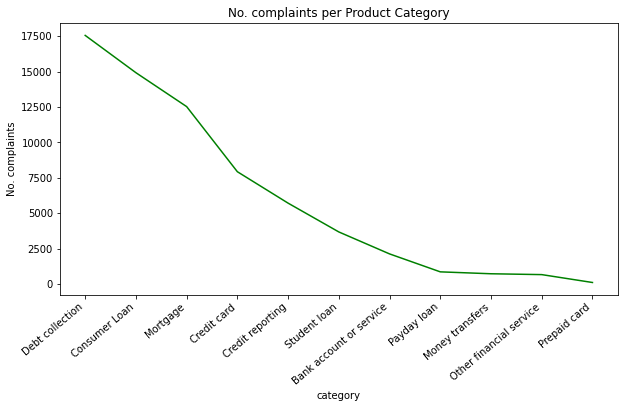

In [ ]:
#Category of product that received most consumer_complaint_narrative
#Top 3 - Debt Collection, Student Loan, Mortgage
x = df['product'].unique()
y = df['product'].value_counts()

plt.figure(figsize=(10,5))
plt.plot(x, y, color='green')
plt.xlabel('category')
plt.ylabel('No. complaints')
plt.title('No. complaints per Product Category')
plt.xticks(rotation=400,horizontalalignment='right')

In [ ]:
#Split into train and test 
Xtr, Xts, ytr, yts = train_test_split(df['consumer_complaint_narrative'], df['product'])

In [ ]:
tf_idf = TfidfVectorizer(analyzer='word', stop_words='english', 
                         token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
tf_idf.fit(df['consumer_complaint_narrative'])
Xtr_tfidf = tf_idf.transform(Xtr)
Xts_tfidf = tf_idf.transform(Xts)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

pipeline.fit(Xtr, ytr)
train_predictions = pipeline.predict(Xtr)
test_predictions = pipeline.predict(Xts)
pipeline.score(Xts, yts)

classification_report(ytr, train_predictions)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

'                         precision    recall  f1-score   support\n\nBank account or service       0.87      0.84      0.85      4260\n          Consumer Loan       0.85      0.69      0.76      2771\n            Credit card       0.85      0.86      0.86      5910\n       Credit reporting       0.89      0.89      0.89      9447\n        Debt collection       0.85      0.92      0.89     13118\n        Money transfers       0.85      0.62      0.72       504\n               Mortgage       0.94      0.97      0.95     11206\nOther financial service       0.00      0.00      0.00        80\n            Payday loan       0.83      0.37      0.52       564\n           Prepaid card       0.87      0.73      0.79       637\n           Student loan       0.93      0.82      0.87      1607\n\n               accuracy                           0.88     50104\n              macro avg       0.79      0.70      0.74     50104\n           weighted avg       0.88      0.88      0.88     50104\n'

In [ ]:
tf_idf.get_feature_names_out()

array(['000a', '000dollars', '000if', ..., 'zooms', 'ztuff', 'zwicker'],
      dtype=object)

In [ ]:
LR_Model = LogisticRegression()
LR_Model.fit(Xtr_tfidf, ytr)
yhat = LR_Model.predict(Xts_tfidf)
accuracy_score(yts, yhat) 
#0.852891869237217

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8457071009459944

In [ ]:
text = ["house payment refused"]
text_features = tf_idf.transform(text)
predictions = LR_Model.predict(text_features)
print(text)
print("Predicted as: '{}'".format(predictions[0]))

['house payment refused']
Predicted as: 'Mortgage'
